# MAT-3: Markov chain Monte-Carlo 

## 0. Package installation & importing

In [ ]:
install.packages(c("MASS", "ggplot2", "codetools", "tidyr", "devtools", "mcmcse", "plotly", "rgl", "pracma"))
devtools::install_github("Non-Contradiction/autodiffr")

In [2]:
library(MASS)
library(mvtnorm)
library(ggplot2)
library(codetools)
library(R6)
library(tidyr)
library(dplyr)
library(mcmcse)
library(plotly)
library(scatterplot3d)

## 1. Methodology

### 1.1. Metropolis-Hastings

In [3]:
MHS <- R6Class("MHS",
              public = list(
                  samples = NULL, niter = 1000, nburn = 3, burnin = FALSE, dim = NULL,
                  sigma = NULL, x0 = NULL, name="MHS",
                  target.prob = NULL, target.prob.log = NULL,
                  
                  initialize = function(f, f.log, f.log.grad, dim, niter, burnin=TRUE, x0, sigma, const, epsilon, nleaps) {
                      if (missing(f)) stop("Target undefined")
                      self$target.prob <- f
                      if (missing(f.log)) stop("Target log undefined")
                      self$target.prob.log <- f.log
                      if (missing(dim)) stop("Dimensions undefined")
                      self$dim <- dim
                      if (missing(sigma)){
                          self$sigma <- diag(dim)
                          # A <- matrix(runif(dim^2)*10-5, ncol=dim) 
                          # self$sigma <- t(A) %*% A
                      }else self$sigma <- sigma
                      if (missing(sigma)) self$x0 <- rnorm(dim, sd = 5)
                      else self$x0 <- x0
                      if (!missing(niter)) self$niter <- niter
                      self$samples <- matrix(NA, nrow=self$niter, ncol=self$dim+1)
                      self$burnin <- burnin
                  },
                  proposal = function(x){
                      return(rmvnorm(1, mean=rep(0, self$dim), sigma=2.4^2*self$sigma/self$dim))
                  },
                  proposal.prob = function(x){
                      return(dmvnorm(x=x, mean=rep(0, self$dim), sigma=2.4^2*self$sigma/self$dim))
                  },
                  proposal.prob.log = function(x){
                      return(log(dmvnorm(x=x, mean=rep(0, self$dim), sigma=2.4^2*self$sigma/self$dim)))
                      # return(-0.5 * (self$dim * log(2*pi) + log(self$sigma) + t(x) %*% solve(self$sigma) %*% x))
                  },
                  sample_loop = function(){
                      p0 <- self$x0
                      p <- p0
                      
                      start.time <- Sys.time()
                      for (i in 1:self$niter){
                          p <- self$proposal(p)
                          p_prob.log <- self$proposal.prob.log(p)
                          t_prob.log <- self$target.prob.log(p)

                          p0_prob.log <- self$proposal.prob.log(p0)
                          t0_prob.log <- self$target.prob.log(p0)
                          
                          logr <- (t_prob.log - p_prob.log) - (t0_prob.log - p0_prob.log)
                          
                          if (is.nan(logr)) next
                          
                          if (log(runif(1)) < logr) p0 <- p
                          curr.time <- Sys.time()
                          self$samples[i,] <- c(curr.time - start.time, p0)
                      }
                      return(self$samples)
                  },                  
                  sample = function(){
                      if (self$burnin){
                          for (i in 1:self$nburn){
                              S_b <- self$sample_loop()
                              self$sigma <- cov(S_b[,2:ncol(S_b)], use="complete.obs")
                              if (all(self$sigma < 1)){
                                  # print(self$sigma)
                                  if (all(self$sigma < 1) == 1) self$sigma <- diag(self$dim)
                                  self$sigma <- self$sigma / max(abs(self$sigma))
                                  # print(self$sigma)
                              }
                          }
                          self$samples <- matrix(NA, nrow=self$niter, ncol=self$dim+1)  # clear burn-in samples
                      }                    
                      
                      return(self$sample_loop())
                  }
              ))

### 1.2. HMC

In [24]:
first_nan <- NULL
h0 <- NULL
h1 <- NULL
plog_tmp <- NULL
p_tmp <- NULL
plog <- NULL
prop <- NULL
x_tmp <- NULL
hpx <- NULL

HMC <- R6Class("HMC",
              public = list(
                  samples = NULL, niter = 1000, nburn = 1, burnin = FALSE, dim = NULL,
                  sigma = NULL, x0 = NULL, name="HMC",
                  target.prob = NULL, target.prob.log = NULL, target.prob.log.grad = NULL,
                  nleaps = 10, momentum = NULL, m0 = NULL, mL = NULL, eps = 1,
                  
                  initialize = function(f, f.log, f.log.grad, dim, niter, burnin=TRUE, x0, sigma, const, epsilon, nleaps) {
                      if (missing(f)) stop("Target undefined")
                      self$target.prob <- function(x) return(-f(x))
                      if (missing(f.log)) stop("Target log undefined")
                      self$target.prob.log <- function(x) return(-f.log(x))
                      if (missing(f.log.grad)) stop("Target gradient undefined")
                      self$target.prob.log.grad <- function(x) return(-f.log.grad(x))
                      if (missing(dim)) stop("Dimensions undefined")
                      self$dim <- dim
                      if (missing(sigma)){
                          self$sigma <- diag(dim)
                          # A <- matrix(runif(dim^2)*10-5, ncol=dim) 
                          # self$sigma <- t(A) %*% A
                      }else self$sigma <- sigma
                      if (missing(sigma)) self$x0 <- rnorm(dim, sd = 1)
                      else self$x0 <- x0
                      if (!missing(niter)) self$niter <- niter
                      self$samples <- matrix(NA, nrow=self$niter, ncol=self$dim+1)
                      self$burnin <- burnin
                      if (!missing(epsilon)) self$eps <- epsilon
                      if (!missing(nleaps)) self$nleaps <- nleaps
                  },
                  proposal = function(x){
                      p <- t(rmvnorm(1, mean=rep(0, self$dim), sigma=2.4^2*self$sigma/self$dim))
                      self$m0 <- p
                      
                      for (i in 1:self$nleaps){
                          x_p0 <- x
                          
                          p <- p - 0.5 * self$eps * self$target.prob.log.grad(x)
                          x <- x + self$eps * solve(self$sigma) %*% p
                          p <- p - 0.5 * self$eps * self$target.prob.log.grad(x)
                          
                          if (any(is.nan(x)) & is.null(first_nan)) {
                              print("HELLO, QORS")
                              print(x_p0)
                          }
                      }
                      self$mL <- p
                      
                      return(x)
                  },
                  hamiltonian = function(x, p){
                      plog_tmp <<- self$target.prob.log(x)
                      p_tmp <<- p
                      x_tmp <<- x
                      return(self$target.prob.log(x) + 0.5 * t(p) %*% solve(self$sigma) %*% p)
                  },
                  sample_loop = function(){
                      p0 <- t(t(self$x0))
                      p <- p0
                      
                      start.time <- Sys.time()
                      for (i in 1:self$niter){
                          p <- self$proposal(p)
                          
                          logr <- self$hamiltonian(p0, self$m0) - self$hamiltonian(p, self$mL)
                          
                          if (is.nan(logr)){
                              if (is.null(first_nan)){ 
                                  first_nan <<- i
                                  h0 <<- self$hamiltonian(p0, self$m0)
                                  h1 <<- self$hamiltonian(p, self$mL)
                                  plog <<- plog_tmp
                                  prop <<- p_tmp
                                  hpx <<- x_tmp
                              }
                              next
                          }
                          
                          if (log(runif(1)) < logr) p0 <- p
                          curr.time <- Sys.time()
                          self$samples[i,] <- c(curr.time - start.time, p0)
                      }
                      return(self$samples)
                  },                  
                  sample = function(){
                      if (self$burnin){
                          for (i in 1:self$nburn){
                              S_b <- self$sample_loop()
                              self$sigma <- cov(S_b[,2:ncol(S_b)], use="complete.obs")
                              if (all(self$sigma < 1)){
                                  if (all(self$sigma < 1) == 1) self$sigma <- diag(self$dim)
                                  self$sigma <- self$sigma / max(abs(self$sigma))
                              }
                          }
                          self$samples <- matrix(NA, nrow=self$niter, ncol=self$dim+1)  # clear burn-in samples
                      }                    
                      
                      return(self$sample_loop())
                  }
              ))

### 1.3. Rejection sampling

In [5]:
RS <- R6Class("RS",
              public = list(
                  samples = NULL, niter = 1000, nburn = 3, burnin = FALSE, dim = NULL,
                  sigma = NULL, x0 = NULL, name="RS",
                  target.prob = NULL, target.prob.log = NULL, M = NULL,
                  
                  initialize = function(f, f.log, f.log.grad, dim, niter, burnin=TRUE, x0, sigma, const, epsilon, nleaps) {
                      if (missing(f)) stop("Target undefined")
                      self$target.prob <- f
                      if (missing(f.log)) stop("Target log undefined")
                      self$target.prob.log <- f.log
                      if (missing(dim)) stop("Dimensions undefined")
                      self$dim <- dim
                      if (missing(sigma)){
                          self$sigma <- diag(dim)
                      }else self$sigma <- sigma
                      if (missing(const)) self$M <- 0
                      else self$M <- log(const)
                      if (missing(sigma)) self$x0 <- rnorm(dim, sd = 5)
                      else self$x0 <- x0
                      if (!missing(niter)) self$niter <- niter
                      self$samples <- matrix(NA, nrow=self$niter, ncol=self$dim+1)
                      self$burnin <- burnin
                  },
                  proposal = function(x){
                      return(rmvnorm(1, mean=rep(0, self$dim), sigma=2.4^2*self$sigma/self$dim))
                  },
                  proposal.prob = function(x){
                      return(dmvnorm(x=x, mean=rep(0, self$dim), sigma=2.4^2*self$sigma/self$dim))
                  },
                  proposal.prob.log = function(x){
                      return(log(dmvnorm(x=x, mean=rep(0, self$dim), sigma=2.4^2*self$sigma/self$dim)))
                      # return(-0.5 * (self$dim * log(2*pi) + log(self$sigma) + t(x) %*% solve(self$sigma) %*% x))
                  },
                  sample_loop = function(){
                      p <- self$x0
                      
                      start.time <- Sys.time()
                      for (i in 1:self$niter){
                          p <- self$proposal(p)
                          p_prob.log <- self$proposal.prob.log(p)
                          t_prob.log <- self$target.prob.log(p)
                          
                          logr <- (t_prob.log - p_prob.log - self$M)
                          
                          if (is.nan(logr)) next
                          
                          if (log(runif(1)) > logr) next
                          curr.time <- Sys.time()
                          self$samples[i,] <- c(curr.time - start.time, p)
                      }
                      return(self$samples)
                  },                  
                  sample = function(){
                      if (self$burnin){
                          for (i in 1:self$nburn){
                              S_b <- self$sample_loop()
                              self$sigma <- cov(S_b[,2:ncol(S_b)], use="complete.obs")
                          }
                          self$samples <- matrix(NA, nrow=self$niter, ncol=self$dim+1)  # clear burn-in samples
                      }                    
                      
                      return(self$sample_loop())
                  }
              ))

### 1.4. Plots

In [6]:
# SHOULD I USE MEAN: DECREASES VARIANCE
traceplot <- function(df){
    tf <- tibble(df)
    xlen <- dim(df.bivar)[2]-5
    xcols <- paste0(rep("x"), seq(xlen))
    # print(xlen)
    tf <- gather(df, key = "param", value = "d", xcols)
    tf["tune"][tf$tune, ] <- "tuned"
    tf["tune"][tf$tune != "tuned", ] <- "~tuned"
    rf <- tf %>% group_by(across(all_of(c("alg", "run", "iter", "tune", "param")))) %>% 
                 summarise_at(vars("d"), list(d = mean))
    # print(head(rf))
    # show only largest and smallest xvalues and middle
    # TODO: if neccesarry
    g <- ggplot(rf, aes(x=iter, y=d, group=param)) + geom_line(aes(color=param), alpha=.4)
    return(g + facet_wrap(~tune + alg, nrow=2))
}

# autocorrelation
autocorr <- function(df){
    dlen <- dim(df)[2]-5
    xcols <- paste0(rep("x"), seq(dlen))
    lcols <- paste0(rep("lag_x"), seq(dlen))
    rf <- data.frame(matrix(ncol=2 * dlen + 2, nrow=0))
    colnames(rf) <- c("alg", "tune", "var", "lag", "val")
    for (a in unique(df$alg)){
            for (t in unique(df$tune)){
                for (xcol in xcols){
                    for (i in 1:5){
                        plt <- acf(df[(df$run == i) & (df$alg == a) & (df$tune == t), xcol], lag.max = 100, na.action=na.pass, plot = FALSE)
                        for (j in c(1)){
                            for (k in c(1)){
                                cbplt <- cbind(plt$lag[,k,j], plt$acf[,k,j])
                                rf <- rbind(rf, cbind(matrix(rep(a, dim(cbplt)[1]), ncol = 1), matrix(rep(t, dim(cbplt)[1]), ncol = 1), matrix(rep(xcol, dim(cbplt)[1]), ncol = 1), cbplt))
                            }
                        }                
                    }
                }
            }
    }
    colnames(rf) <- c("alg", "tune", "var", "lag", "val")
    rf <- transform(rf, tune = as.logical(tune), lag = as.numeric(lag), val = as.numeric(val))
    gf <- aggregate(. ~ alg+tune+var+lag, data=rf, FUN=mean)
    gf <- rf[rf$lag > 0,]
    gf[,"lag"] <- ceiling(gf$lag / 10) * 10
    gf_sd <- aggregate(. ~ alg+tune+var+lag, data=gf, FUN=function(x) return(sqrt(var(x))))
    gf <- aggregate(. ~ alg+tune+var+lag, data=gf, FUN=mean)
    gf[, "sd"] <- gf_sd$val
    g <- ggplot(data=gf, aes(x=lag, y=val, fill=alg)) + geom_bar(stat="identity", position=position_dodge(5), width=3) +
                       geom_errorbar(aes(ymin=val-sd, ymax=val+sd), width=.1, position=position_dodge(5)) + facet_wrap(~tune+var)
    return(g)
}

# ESS
wess <- function(df){
    df <- na.omit(df)
    dlen <- dim(df)[2]-5
    xcols <- paste0(rep("x"), seq(dlen))
    rf <- data.frame(matrix(ncol=dlen + 2, nrow=0))
    colnames(rf) <- c("alg", "tune", xcols)

    dlen <- dim(df)[2]-5
    xcols <- paste0(rep("x"), seq(dlen))
    rf <- data.frame(matrix(ncol=dlen, nrow=0))
    colnames(rf) <- xcols

    for (a in unique(df$alg)){
        for (t in unique(df$tune)){
            for (i in 1:5){
                ess_i <- ess(df[(df$run == i) & (df$alg == a) & (df$tune == t), xcols])
                ess_i <- c(a, t, ess_i)
                rf <- rbind(rf, ess_i)
            }
        }
    }
    colnames(rf) <- c("alg", "tune", xcols)
    mu_rf <- aggregate(. ~ alg + tune, data=rf, FUN=function(x) mean(as.numeric(x)))
    std_rf <- aggregate(. ~ alg + tune, data=rf, FUN=function(x) sqrt(var(as.numeric(x))))
    rf <- cbind(mu_rf, std_rf[, xcols])
                        
    return(rf[order(apply(rf[,xcols], 1, FUN=sum)),])
} 

# ESS per second
wesssec <- function(df){
    df <- na.omit(df)
    dlen <- dim(df)[2]-5
    xcols <- paste0(rep("x"), seq(dlen))
    rf <- data.frame(matrix(ncol=dlen + 2, nrow=0))
    colnames(rf) <- c("alg", "tune", xcols)

    dlen <- dim(df)[2]-5
    xcols <- paste0(rep("x"), seq(dlen))
    rf <- data.frame(matrix(ncol=dlen, nrow=0))
    colnames(rf) <- xcols

    for (a in unique(df$alg)){
        for (t in unique(df$tune)){
            for (i in 1:5){
                idf <- df[df$run == i, c("time", xcols)]
                ess_i <- ess(df[(df$run == i) & (df$alg == a) & (df$tune == t), xcols])
                ess_i <- c(a, t, ess_i / max(idf$time))
                rf <- rbind(rf, ess_i)
            }
        }
    }
    colnames(rf) <- c("alg", "tune", xcols)
    mu_rf <- aggregate(. ~ alg + tune, data=rf, FUN=function(x) mean(as.numeric(x)))
    std_rf <- aggregate(. ~ alg + tune, data=rf, FUN=function(x) sqrt(var(as.numeric(x))))
    rf <- cbind(mu_rf, std_rf[, xcols])
    
    return(rf[order(apply(rf[,xcols], 1, FUN=sum)),])
}

### 1.5 Analysis

In [7]:
generate_results <- function(f, f.log, f.log.grad, dim, const = 1, epsilon = 1, nleaps = 10, tunelist = list(FALSE, TRUE), samplers = list(RS, MHS, HMC)){
    df <- data.frame(matrix(ncol = 7, nrow = 0))
    colnames(df) <- c("alg", "tune", "run", "iter", "time", "x1", "x2")
    niter <- 1000

    # for method in methodology
    for (obj in samplers){
        # apply twice
        for (burnin in tunelist){
            # repeat n-times for uncertainty estimation
            for (i in 1:5) {
                sampler <- obj$new(f = f, f.log = f.log, f.log.grad = f.log.grad, dim = 2, niter = niter, burnin = burnin, epsilon = epsilon, nleaps = nleaps, const = const)
                tp <- sampler$sample()
                df_nsamp <- data.frame(tp)
                colnames(df_nsamp) <- c("time", "x1", "x2")
                df_nsamp$iter <- seq(niter)
                df_nsamp$alg <- sampler$name
                df_nsamp$tune <- burnin
                df_nsamp$run <- i
                df <- rbind(df, df_nsamp)
            }
        }
    }
    return(df)
}

present_results <- function(df, name, keypoints = NULL){
    # check whether shape is correct
    g <- ggplot(df, aes(x=x1, y=x2, color = tune)) + geom_point()
    if (!is.null(keypoints)) 
        g <- g + geom_point(aes(x=keypoints[1], y=keypoints[2]), colour="blue")
    plt <- g + facet_wrap(~alg + tune)
    print(plt)

    # plot traceplot
    options(repr.plot.width=15, repr.plot.height=8)
    plt <- traceplot(df)
    ggsave(paste("./img/", name, "_traceplot.png"), plot = plt, dpi=100)
    print(plt)

    # plot autocorrelation
    plt <- autocorr(df)
    ggsave(paste("./img/", name, "_acf.png"), plot = plt, dpi=100)
    print(plt)


    # calculate ESS
    ress <- wess(df)
    print(ress)
    write.csv(ress, paste("./table/ess-", name, ".csv"), row.names=TRUE) 

    # calculate ESS/second (maybe ESS per second)
    resssec <- wesssec(df)
    print(resssec)
    write.csv(ress, paste("./table/esssec-", name, ".csv"), row.names=TRUE)
}

## 2. Results

### 2.1. Bivariate Normal distribution

Warning message:
“Removed 4236 rows containing missing values (geom_point).”
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



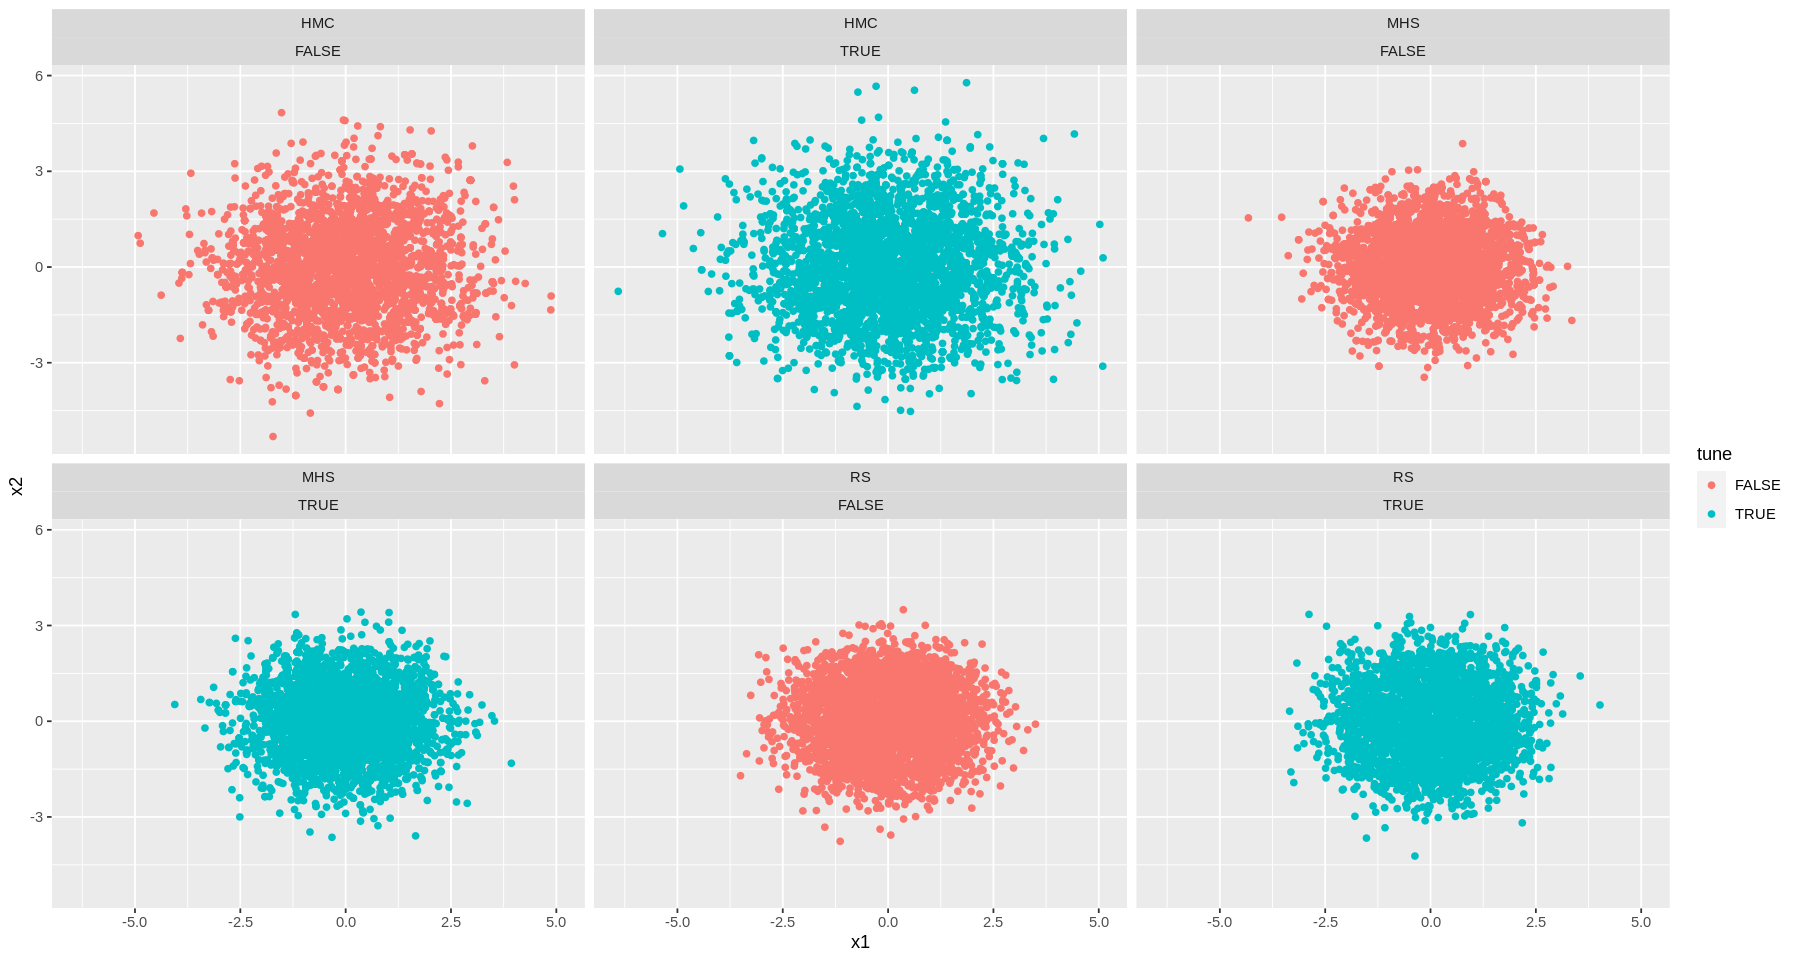

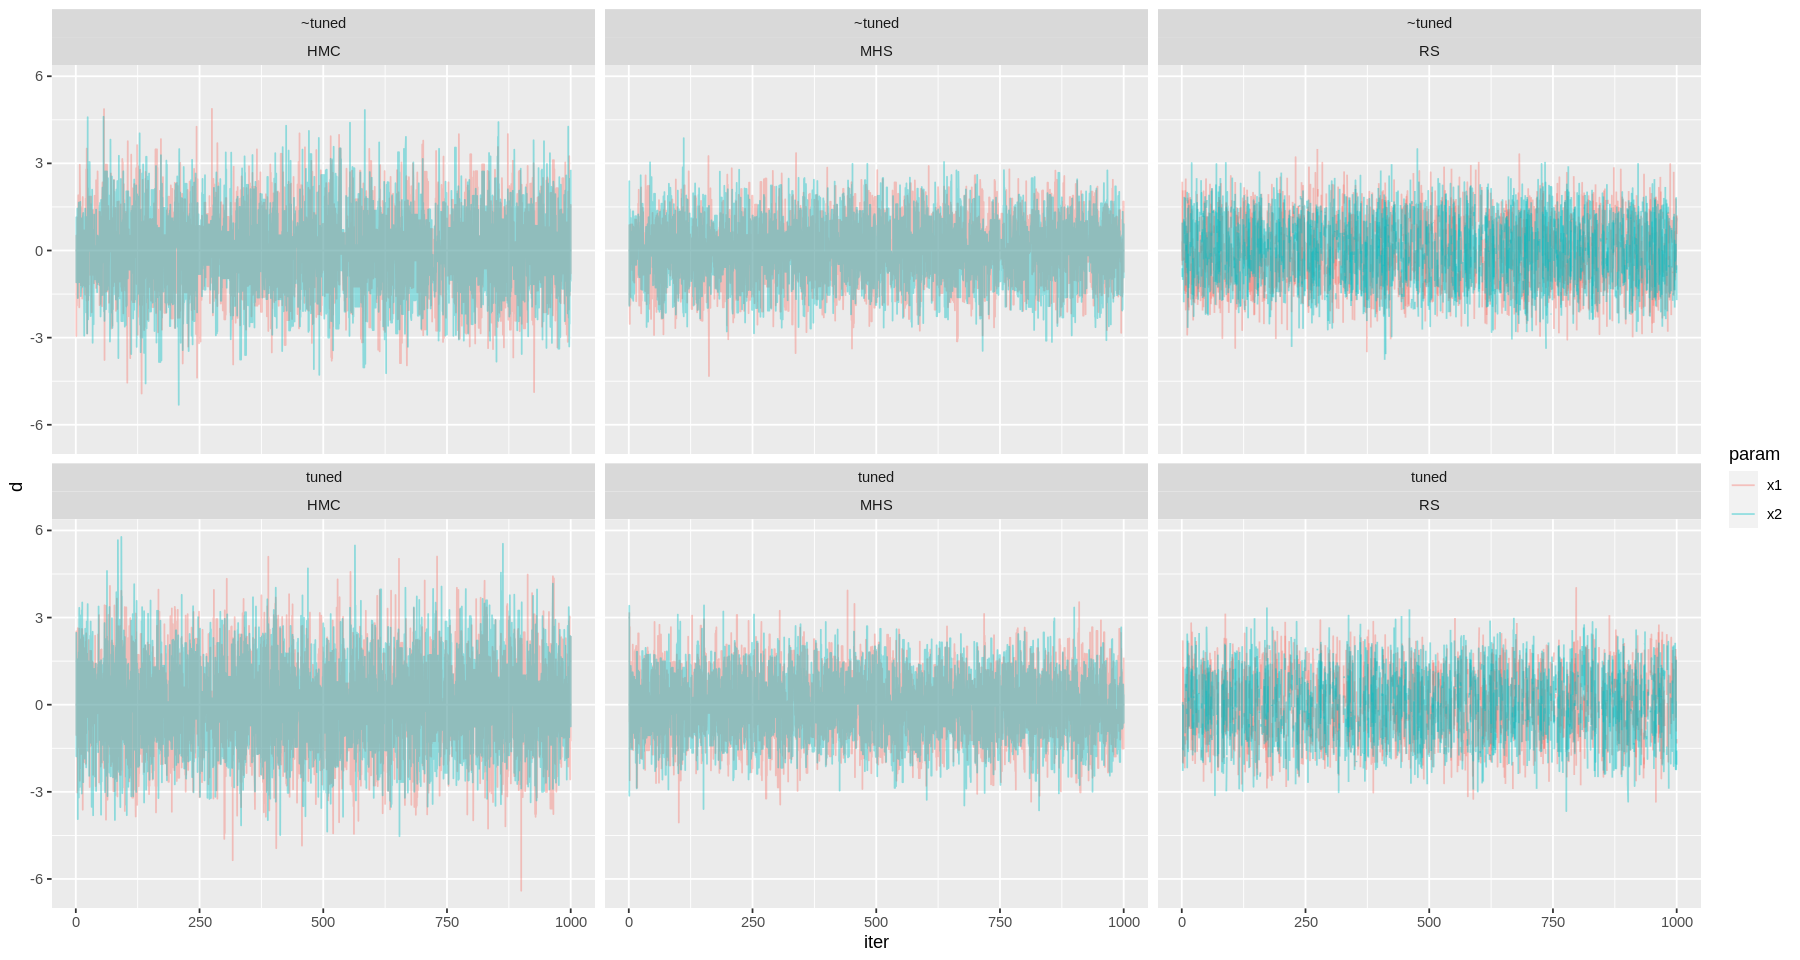

  alg  tune       x1       x2        x1        x2
2 MHS FALSE 387.8353 400.1774  21.39927  75.23241
5 MHS  TRUE 420.3905 454.8225  48.38731  72.06008
1 HMC FALSE 444.5188 497.0052 157.54946 136.46887
6  RS  TRUE 524.6000 524.6000  16.97940  16.97940
3  RS FALSE 611.2898 645.4324  39.77704  48.06498
4 HMC  TRUE 676.9597 643.2284 243.50940 333.52359
  alg  tune       x1       x2        x1        x2
2 MHS FALSE 407.3016 419.9605  25.34800  78.41806
5 MHS  TRUE 441.9963 477.4277  56.94284  75.99983
1 HMC FALSE 467.3684 523.5709 169.53793 151.29529
6  RS  TRUE 551.2198 551.2198  30.67143  30.67143
3  RS FALSE 641.6478 677.7625  40.23729  53.01156
4 HMC  TRUE 710.2836 672.0242 255.83910 343.93359


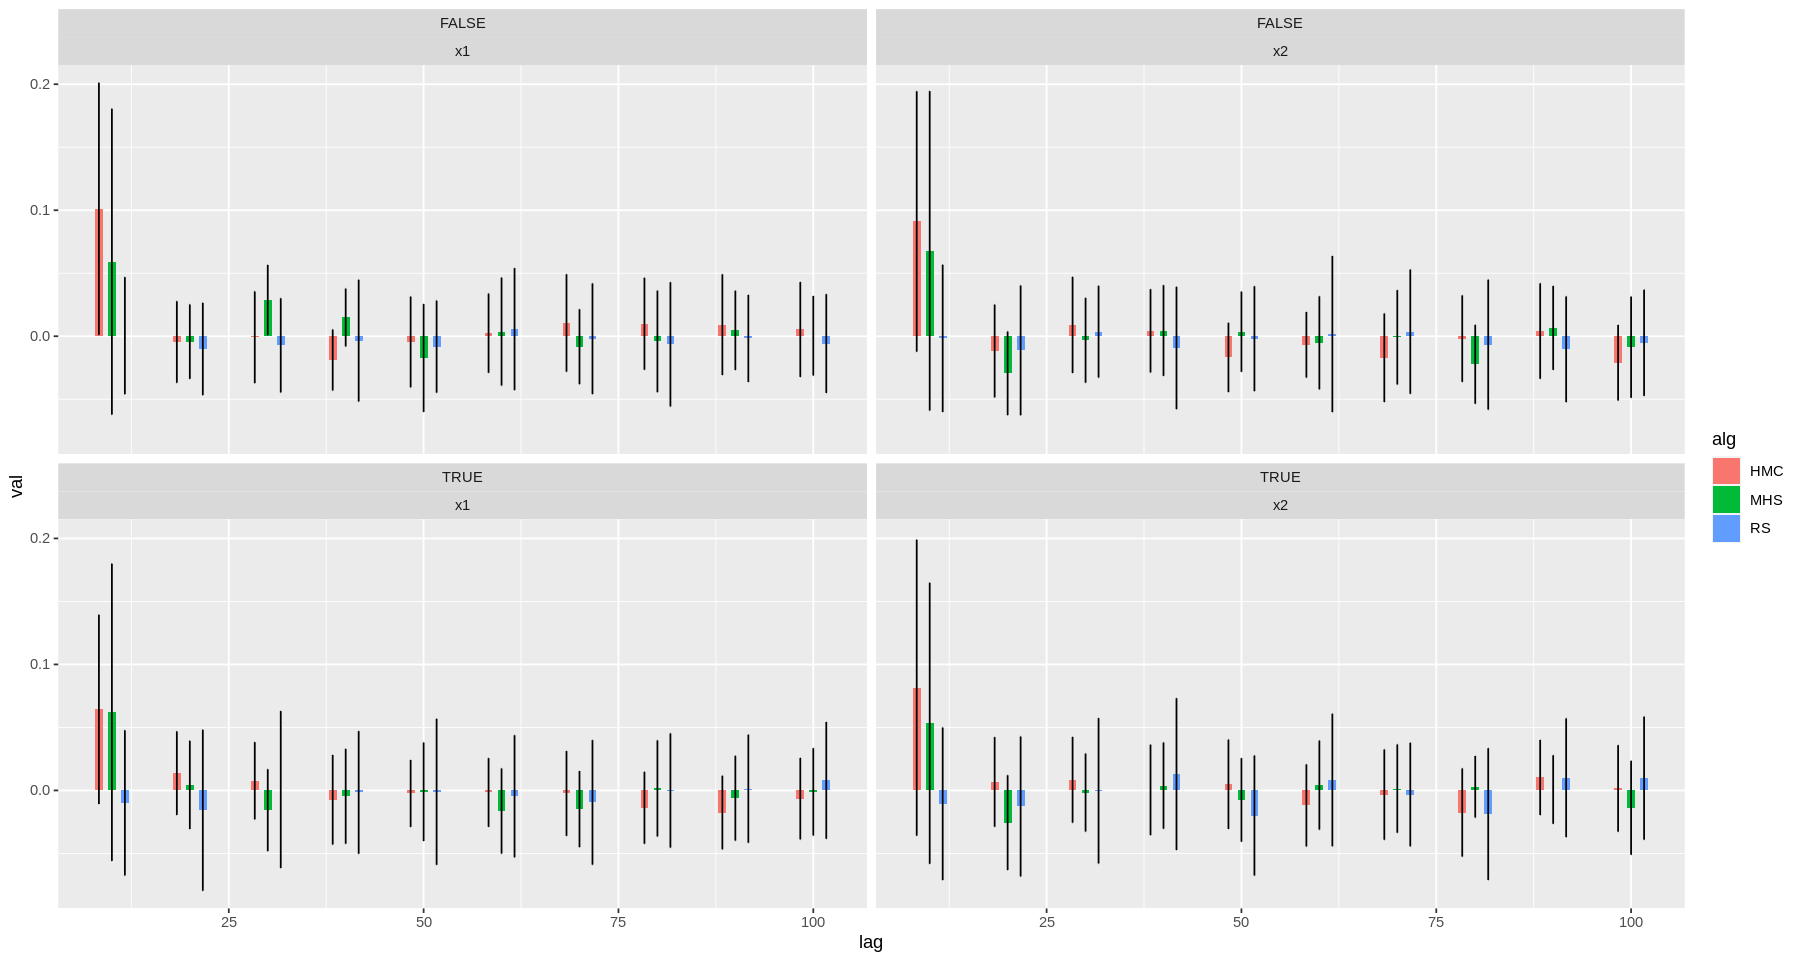

In [20]:
covmat <- diag(2)
# covmat <- matrix(c(2, -1, -1, 2), nrow=2)
bivar.prob = function(x){
    return(dmvnorm(x=c(x), mean=rep(0, 2), sigma=covmat))
}

bivar.prob.log = function(x){
    return(log(dmvnorm(x=c(x), mean=rep(0, 2), sigma=covmat)))
}

bivar.log.grad = function(x){
    return(-solve(covmat) %*% x)
}

df.bivar <- generate_results(f = bivar.prob, f.log = bivar.prob.log, f.log.grad = bivar.log.grad, tunelist = list(FALSE, TRUE), samplers = list(RS, MHS, HMC))

present_results(df.bivar, "bivar")

### 2.2. Banana function 

Warning message:
“Removed 7088 rows containing missing values (geom_point).”
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



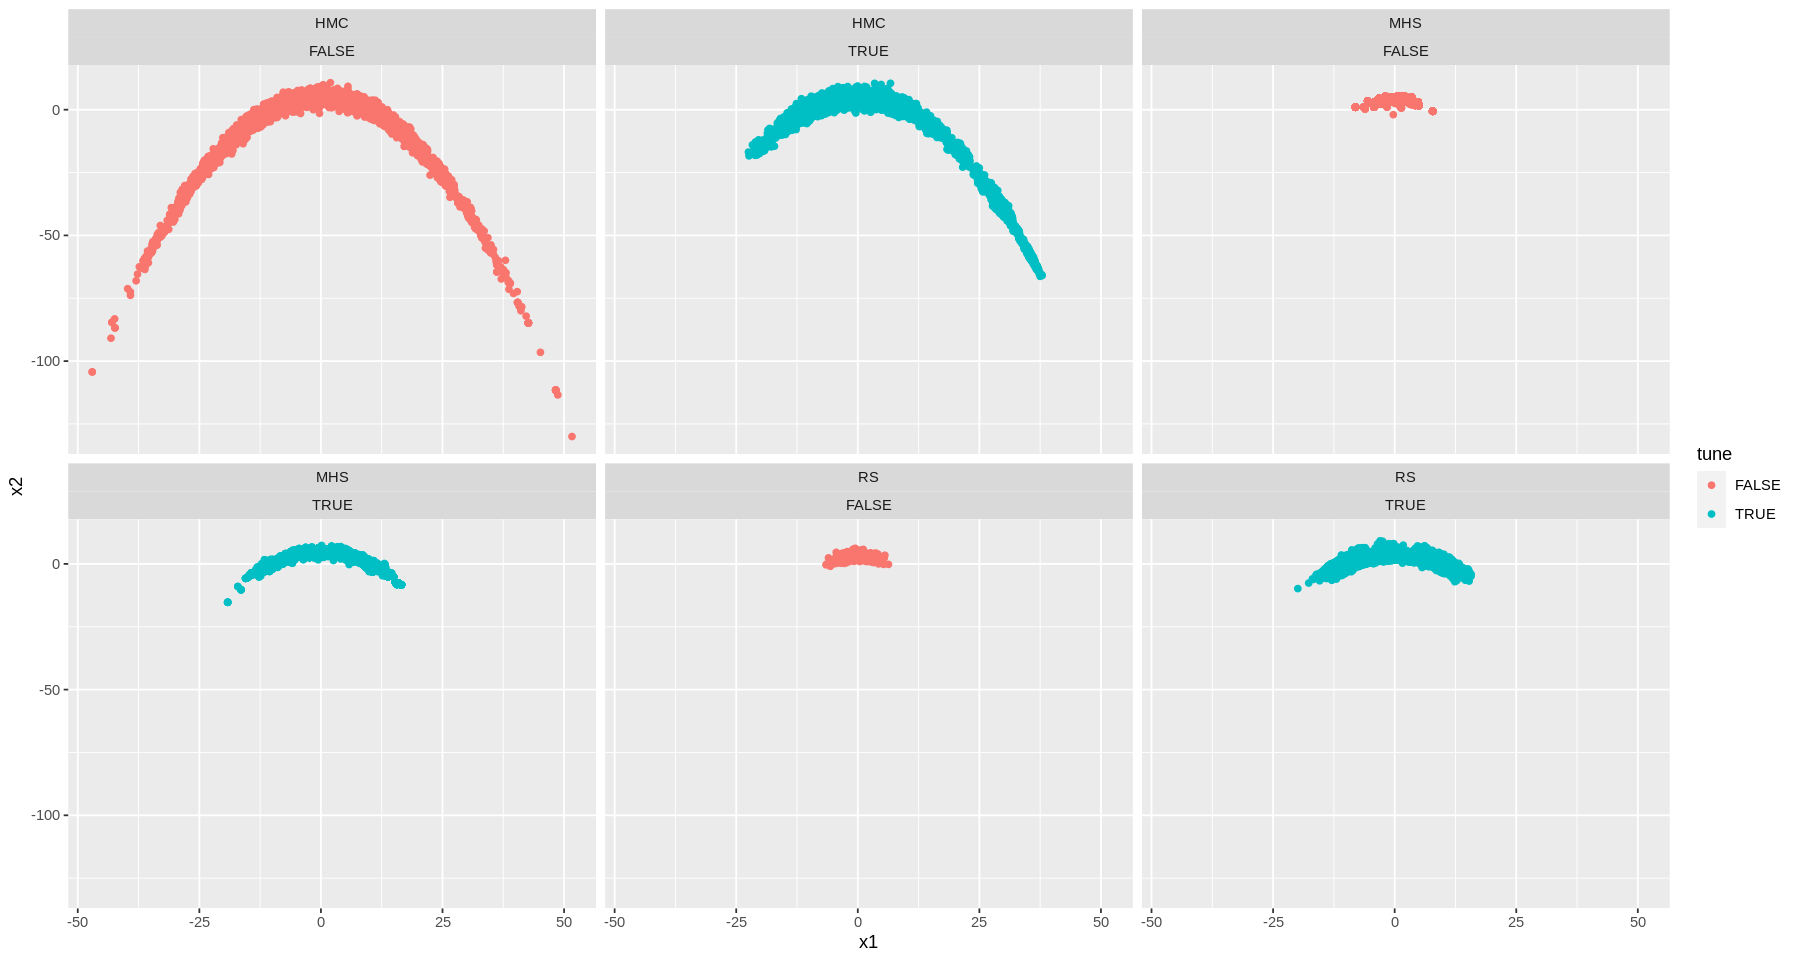

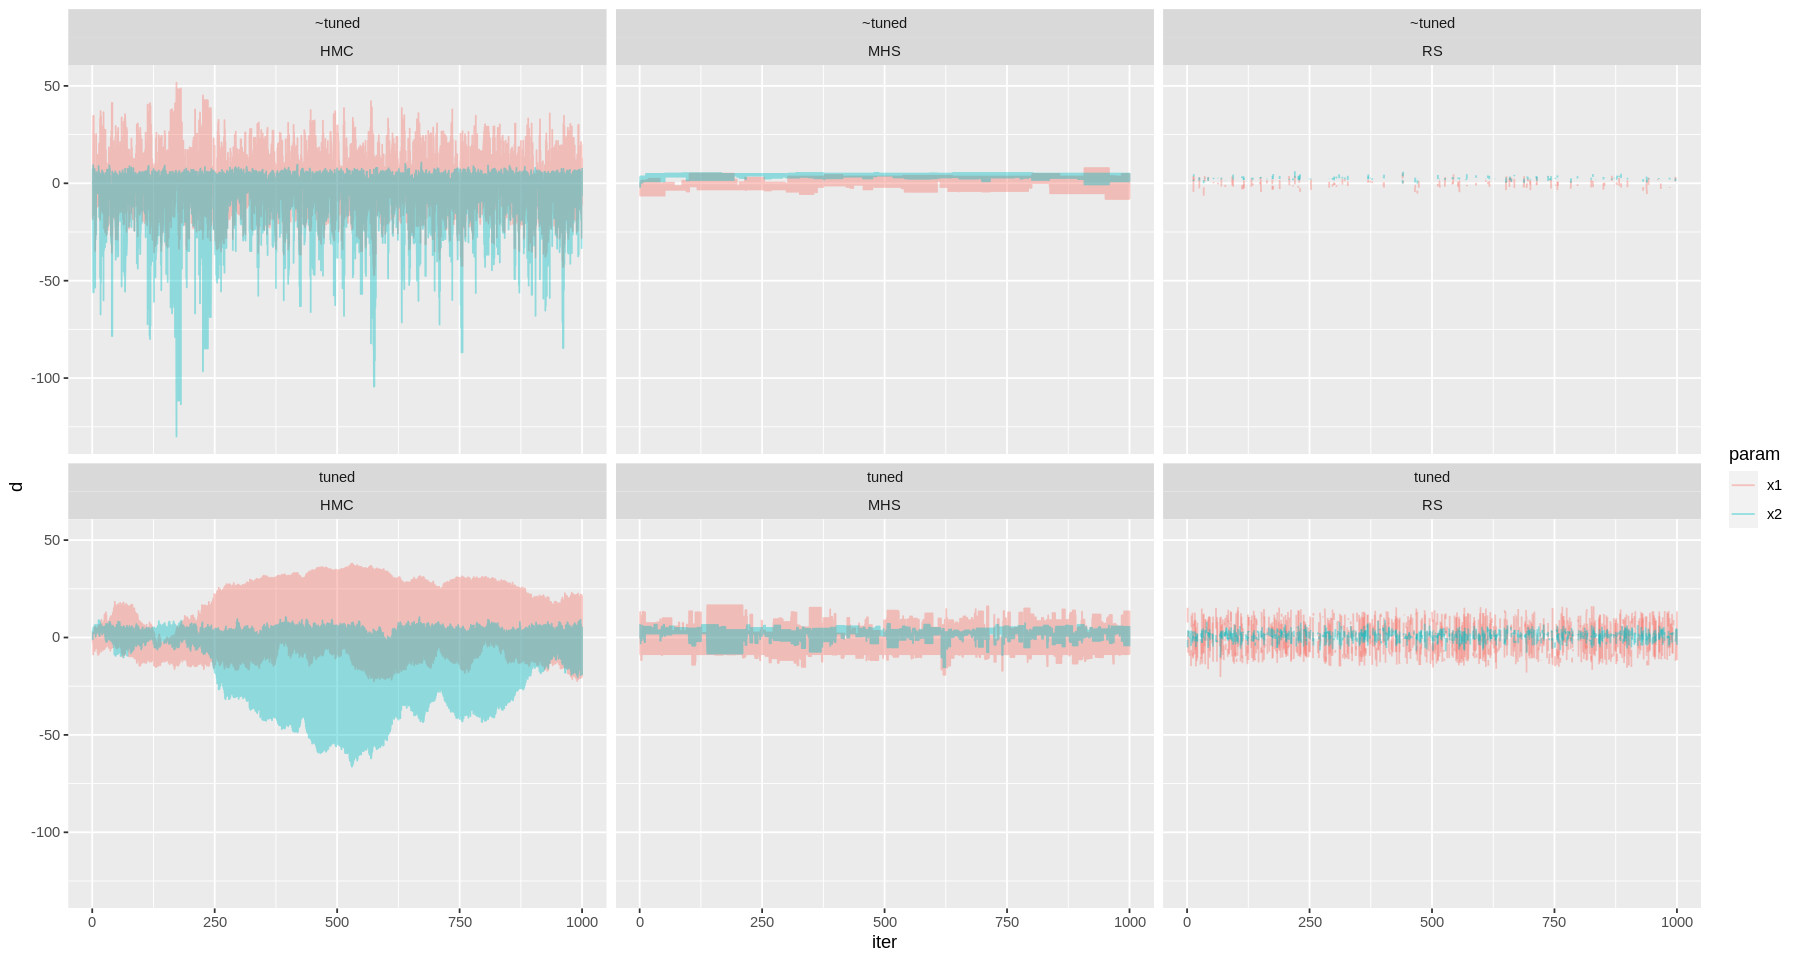

[1] "No variability observed in a component. Setting batch size to 1"
[1] "No variability observed in a component. Setting batch size to 1"
  alg  tune         x1        x2        x1        x2
2 MHS FALSE  15.826485  11.26504  9.716281  3.166398
4 HMC  TRUE   8.869427  22.00070  2.543521 15.183783
3  RS FALSE 164.000000 164.00000 11.202678 11.202678
1 HMC FALSE 212.000359 186.53979 49.694732 88.254123
6  RS  TRUE 418.400000 418.40000 14.621901 14.621901
5 MHS  TRUE        NaN       NaN        NA        NA
[1] "No variability observed in a component. Setting batch size to 1"
[1] "No variability observed in a component. Setting batch size to 1"
  alg  tune         x1         x2        x1        x2
2 MHS FALSE  13.420980   9.537433  8.320702  2.700515
4 HMC  TRUE   7.500935  18.597113  2.132192 12.799308
3  RS FALSE 138.764791 138.764791  9.487380  9.487380
1 HMC FALSE 179.248886 157.557856 41.296948 73.942667
6  RS  TRUE 353.984858 353.984858 11.000824 11.000824
5 MHS  TRUE        NaN   

ERROR: Error in eval(expr, envir, enclos): object 'sampler' not found


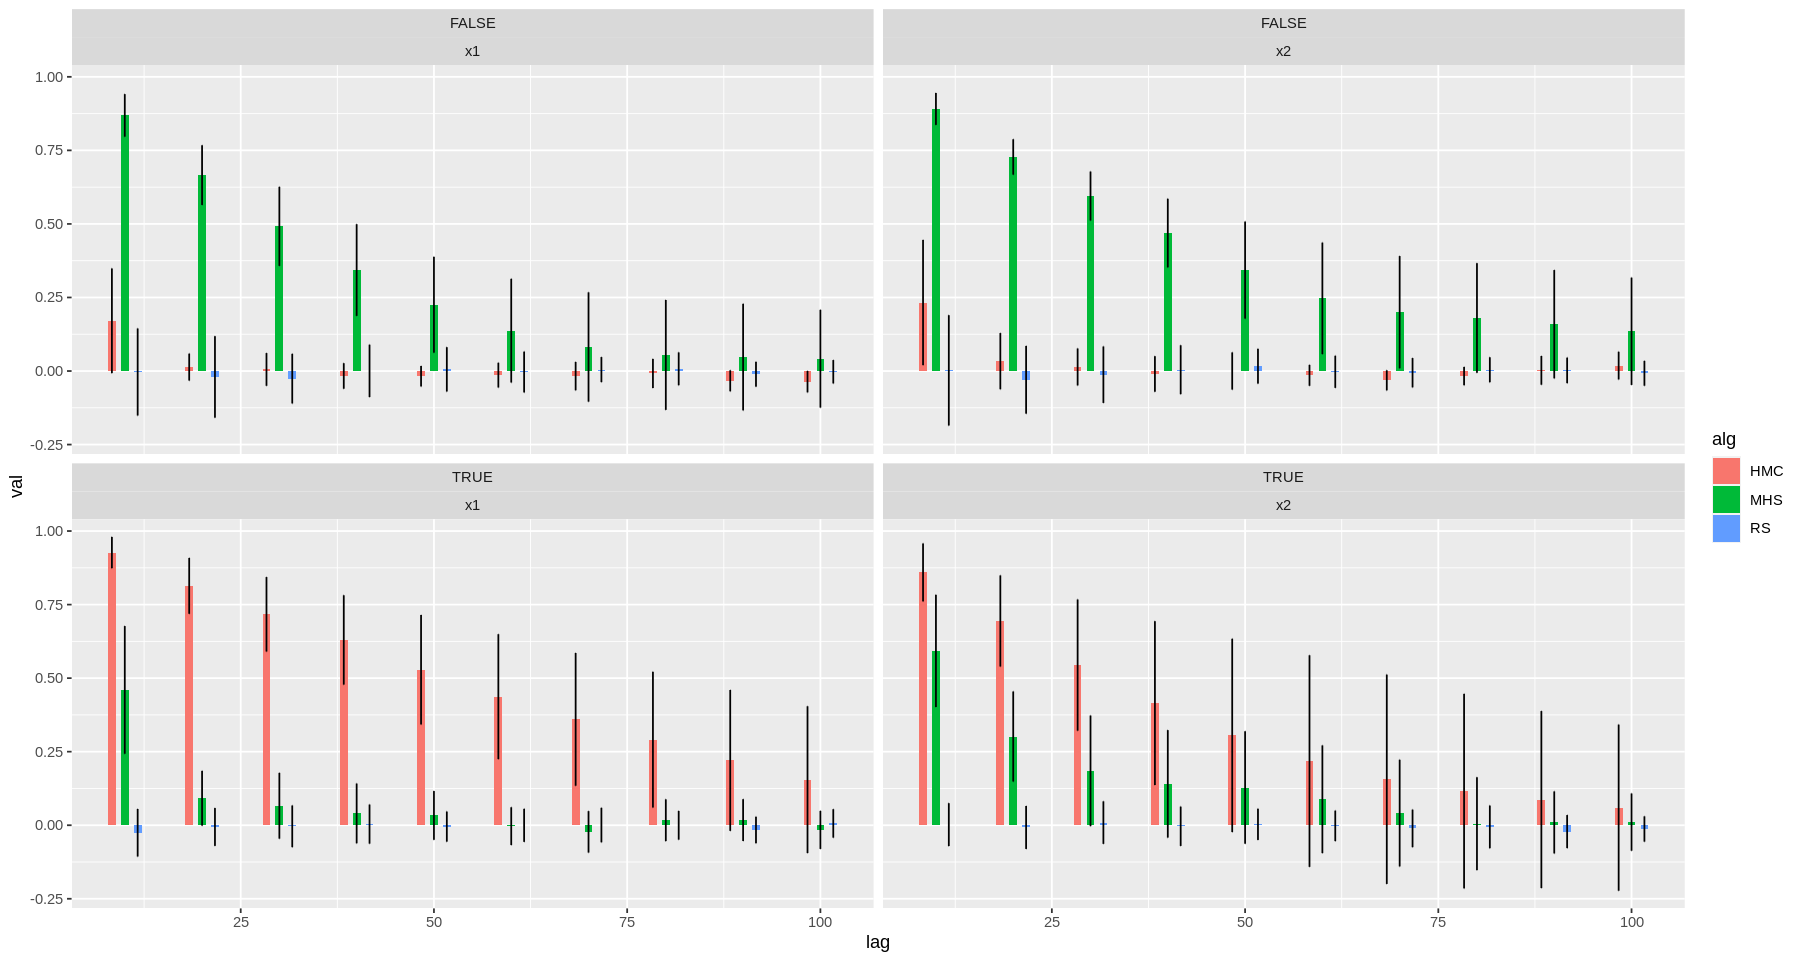

In [11]:
first_nan <- NULL

covmat <- diag(2)
# covmat <- matrix(c(5, -1, -1, 5), nrow=2)
B <- 0.05
banana.prob = function(x){
    return(exp(-(x[1]^2)/200 - 0.5 * (x[2] + B * x[1]^2 - 100 * B)^2))
}

banana.prob.log = function(x){
    return(-(x[1]^2)/200- 0.5 * (x[2]+ B * x[1]^2 - 100*B)^2)
}

banana.log.grad = function(x){
    g1 <- -(x[1])/100- 1.0 * (2* B * x[1]) * (x[2]+ B * x[1]^2 - 100*B)
    g2 <- - 1.0 * (x[2]+ B * x[1]^2 - 100*B)
    return(c(g1,g2))
}

df.banana <- generate_results(f = banana.prob, f.log = banana.prob.log, f.log.grad = banana.log.grad, epsilon = 0.3, nleaps = 50)

present_results(df.banana, "banana")

sampler$sigma

print(h0)
print(h1)
print("")
print(plog)
print(prop)

In [ ]:
df <- df.banana
head(df[(df$alg == "HMC") & (!df$tune),], 20)

### 2.3. Logistic regression likelihood (two columns)

In [27]:
dataset <- read.csv(file = '/home/bro/Documents/mat/HW3/datset.csv')
X <- data.matrix(dataset[,c("X1", "X2")])
y <- data.matrix(dataset[,c("y")])

keypoints <- c(1.36245, -0.70776)

covmat <- diag(2)
binom.prob = function(x){
    return(NULL) # not implemented
}

binom.prob.log = function(theta){
    if (dim(theta) ) # give theta proper dimensions NULL -> (2,1)
    z = X %*% theta
    return(-sum(log(1 + exp(-z)) + (1 - y) * z))
}

tX <- NULL
tz <- NULL

binom.log.grad = function(theta){
    # print(dim(theta))
    z = exp(-(X %*% theta))
    tX <<- t(X)
    tz <<- z/(1+z)
    return(tX %*% tz - tX %*% (1 - y))
}

df.binom <- generate_results(f = binom.prob, f.log = binom.prob.log, f.log.grad = binom.log.grad, tunelist = list(FALSE), samplers = list(MHS ,HMC), epsilon = 0.1, const = 1, nleaps = 50)

present_results(df.binom, "binom", keypoints = keypoints)

sampler$sigma

ERROR: Error in X %*% theta: non-conformable arguments


In [ ]:
df.binom

In [ ]:
model <- glm(y ~.,family=binomial(link='logit'), data=dataset[,c("X1", "X2", "y")])
summary(model)

In [ ]:
# plot function
X <- data.matrix(dataset[,c("X1", "X2")])
y <- data.matrix(dataset[,c("y")])

x <- seq(-50, 50, 1)
D <- expand.grid(x, x)
z <- matrix(apply(D, 1, binom.prob.log))

scatterplot3d(D[,1], D[,2], z, pch = 1, angle = 45)


In [ ]:
D[which(z==max(z)),]

In [ ]:
max(z)

In [ ]:
fuck <- NULL

X <- data.matrix(dataset[,c("X1", "X2", "X3", "X4", "X5", "X6", "X7", "X8", "X9", "X10", "X11")])
y <- data.matrix(dataset[,c("y")])

binom.prob.log = function(theta){
    fuck <<- theta
    if (is.null(dim(theta))) theta <- t(theta) # give theta proper dimensions NULL -> (2,1)
    z = X %*% t(theta)
    # print(z)
    return(sum(log(1 + exp(-z)) + (1 - y) * z))
}

# find function minimum
optim(runif(11), fn = binom.prob.log, method = "L-BFGS")

### 2.4. Logistic regression likelihood (all columns)

In [ ]:
dataset <- read.csv(file = '/home/bro/Documents/mat/HW3/datset.csv')

X <- data.matrix(dataset[,c("X1", "X2", "X3", "X4", "X5", "X6", "X7", "X8", "X9", "X10", "X11")])
y <- data.matrix(dataset[,c("y")])

covmat <- diag(2)
binom.prob = function(x){
    return(NULL) # not implemented
}

binom.prob.log = function(theta){
    fuck <<- theta
    if (is.null(dim(theta))) theta <- t(theta) # give theta proper dimensions NULL -> (2,1)
    z = X %*% t(theta)
    return(-sum(log(1 + exp(-z)) + (1 - y) * z))
}

df.binom <- data.frame(matrix(ncol = 7, nrow = 0))
colnames(df.binom) <- c("alg", "tune", "run", "iter", "time", "x1", "x2")
niter <- 1000
samplers <- list(MHS)

# for method in methodology
for (obj in samplers){
    # apply twice
    for (burnin in list(FALSE, TRUE)){
        # repeat n-times for uncertainty estimation
        for (i in 1:5) {
            sampler <- obj$new(binom.prob, binom.prob.log, 11, niter, burnin)
            tp <- sampler$sample()
            df_nsamp <- data.frame(tp)
            colnames(df_nsamp) <- c("time", paste0(rep("x"), seq(11)))
            df_nsamp$iter <- seq(niter)
            df_nsamp$alg <- sampler$name
            df_nsamp$tune <- burnin
            df_nsamp$run <- i
            df.binom <- rbind(df.binom, df_nsamp)
        }
    }
}

# check whether shape is correct
ggplot(df.binom, aes(x=x1, y=x2, color = tune)) + geom_point()

# plot traceplot
options(repr.plot.width=15, repr.plot.height=8)
plt <- traceplot(df.binom)
ggsave("./img/binom_traceplot2.png", plot = plt, dpi=100)
plt

# plot autocorrelation
options(repr.plot.width=10, repr.plot.height=12)
plt <- acf(df.binom[,2:12], lag.max = 100)
# ggsave("./img/bivar_acf.png", plot = plt, dpi=300)
# plt

# calculate ESS
ress <- wess(df.binom)
ress
write.csv(ress, "./table/ess-binom2.csv", row.names=TRUE) 

# calculate ESS/second (maybe ESS per second)
resssec <- wesssec(df.binom)
resssec
write.csv(ress, "./table/esssec-binom2.csv", row.names=TRUE) 

# TODO: Fix Error

### 3. Discussion

TODO